In [ ]:
!pip install mne pyedflib tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.5 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 79.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 50.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.1/902.1 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.6 MB/s eta 0:00:00


In [ ]:
import os, glob, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import mne, csv, pathlib
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/loc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ---------- FULL REPLACEMENT CELL: Dynamic STGNN integrated with your CHB loader ----------
# Run after mounting Drive and installing libs.

import os, glob, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import mne, csv, pathlib, re
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from torch_geometric.data import Data, Batch
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from pathlib import Path

# ----------------- Config (tweak these) -----------------
BASE_PATH = "/content/drive/MyDrive/chb_data"   # your CHB folder
SUBJECT = "chb01"                               # subject subfolder used earlier
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

WIN_SECS = 10
STEP_SECS = 5
SEQ_LEN = 4
# Use top-k edges per node instead of hard thresholding for stability
TOP_K = 12
BATCH_SIZE = 8
EPOCHS = 12
LR = 3e-4

# Forecasting specifics
PRE_SECS = 300        # preictal horizon in seconds
EXCLUDE_ICTAL = True  # skip ictal windows
SF_TARGET = 128       # target sampling freq used in resample()

# Aug / robustness
CHANNEL_DROPOUT_P = 0.05   # channel dropout during training
LABEL_DILATION_WINDOWS = 1 # expand positive labels +- windows (0 = none)
SOFT_LABEL_TAU = 120       # controls decay in soft label

# ----------------- Utilities copied & stabilized from your PoC -----------------
def read_seizure_events_from_summary(fpath):
    fpath = Path(fpath)
    subj_dir = fpath.parent
    # find any *_summary.txt or similar
    candidates = [p for p in subj_dir.iterdir() if re.search(r'-summary', p.name, re.IGNORECASE)]
    if not candidates:
        # no summary found (return empty)
        return []
    summary_path = candidates[0]
    events = []
    current_file = None
    with open(summary_path, "r", errors="ignore") as fh:
        lines = [ln.strip() for ln in fh if ln.strip()]
    for i, line in enumerate(lines):
        if line.lower().startswith("file name:"):
            current_file = line.split(":",1)[1].strip()
        elif "seizure start time" in line.lower() and current_file == fpath.name:
            start_match = re.findall(r"[\d\.]+", line)
            start = float(start_match[0]) if start_match else None
            dur = 0.0
            # look ahead for end time
            if i+1 < len(lines) and "seizure end time" in lines[i+1].lower():
                end_match = re.findall(r"[\d\.]+", lines[i+1])
                if end_match and start is not None:
                    end = float(end_match[0]); dur = end - start
            if start is not None:
                events.append((start, dur))
    return events

def load_eeg(fpath):
    raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)
    raw.pick_types(eeg=True)
    raw.resample(SF_TARGET)  # downsample to target SF
    sf = int(raw.info["sfreq"])
    data = raw.get_data()
    return raw, data, sf

# soft preictal probability (smooth label)
def soft_label(window_end_sec, seizure_onsets):
    if len(seizure_onsets) == 0:
        return 0.0
    dists = [max(0.0, onset - window_end_sec) for onset in seizure_onsets]
    d = min(dists)
    if d < PRE_SECS:
        return float(np.exp(-(d**2) / (SOFT_LABEL_TAU**2)))
    return 0.0

# label dilation (expand positives by k windows on both sides)
def dilate_labels_binary(y_windows, k):
    if k <= 0:
        return y_windows
    out = y_windows.copy()
    pos = np.where(y_windows==1)[0]
    for i in pos:
        lo = max(0, i-k); hi = min(len(y_windows), i+k+1)
        out[lo:hi] = 1
    return out

# channel dropout augmentation for data robustness (applied at training graph time)
def channel_dropout(seg, p=0.05):
    seg = seg.copy()
    C = seg.shape[0]
    mask = (np.random.rand(C) > p).astype(float)
    return seg * mask[:,None]

# ----------------- Feature & graph construction (stable top-k) -----------------
def extract_features(eeg_segment, sf):
    feats = []
    for ch in eeg_segment:
        mean_v = ch.mean()
        std_v = ch.std()
        sk = skew(ch)
        kurt = kurtosis(ch)
        # band powers using simple welch
        f, Pxx = welch(ch, fs=sf, nperseg=max(128, sf))
        bp = lambda lo, hi: np.trapz(Pxx[(f>=lo)&(f<=hi)], f[(f>=lo)&(f<=hi)]) if np.any((f>=lo)&(f<=hi)) else 0.0
        bands = [bp(0.5,4), bp(4,8), bp(8,13), bp(13,30), bp(30,70)]
        feats.append([mean_v, std_v, float(sk), float(kurt)] + [float(b) for b in bands])
    return np.array(feats, dtype=np.float32)

def connectivity_matrix(eeg_segment):
    """Absolute correlation matrix with diagonal zeroed."""
    corr = np.corrcoef(eeg_segment)
    corr = np.nan_to_num(np.abs(corr))
    np.fill_diagonal(corr, 0)
    return corr

def build_graph(seg, label, sf, top_k=TOP_K):
    """Top-k edges per node (keeps weights) -> returns torch_geometric.Data."""
    x = extract_features(seg, sf)
    A = connectivity_matrix(seg)
    edges = []
    weights = []
    n = A.shape[0]
    for i in range(n):
        top_idx = np.argsort(A[i])[-top_k:]
        for j in top_idx:
            if i==j: continue
            edges.append((i,j))
            weights.append(A[i,j])
    if len(edges)==0:
        # fallback to complete graph (small channels case)
        for i in range(n):
            for j in range(n):
                if i!=j:
                    edges.append((i,j)); weights.append(A[i,j] if i< A.shape[0] and j < A.shape[1] else 1.0)
    edge_index = np.array(edges).T.astype(np.int64)
    edge_attr = np.array(weights, dtype=np.float32)
    # create Data
    return Data(x=torch.tensor(x, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                y=torch.tensor([label], dtype=torch.float))

# ----------------- Segmenting windows and labeling (uses your logic) -----------------
def segment_data_with_times(raw, data, sf, seizure_events):
    win_len, step = WIN_SECS*sf, STEP_SECS*sf
    segs = []
    rec_dur = data.shape[1] / sf
    for start in range(0, data.shape[1]-win_len+1, step):
        seg = data[:, start:start+win_len]
        seg_start = start / sf
        seg_end = (start + win_len) / sf
        label = 0
        is_ictal = False
        for onset, dur in seizure_events:
            seiz_start = onset
            seiz_end = onset + dur
            if not (seg_end <= seiz_start or seg_start >= seiz_end):
                is_ictal = True
            if (seiz_start - PRE_SECS) <= seg_end < seiz_start:
                label = 1
        if EXCLUDE_ICTAL and is_ictal:
            continue
        segs.append((seg, seg_start, seg_end, label))
    return segs

# ----------------- Build dataset from Drive recursively (keeps per-file grouping) -----------------
def prepare_sequences(base_path, subject_subfolder=SUBJECT, verbose=True):
    # find files
    folder = os.path.join(base_path, subject_subfolder)
    files = sorted(glob.glob(os.path.join(folder, "*.edf")))
    if verbose:
        print("Found EDF files:", len(files))
    file_to_sequences = {}
    all_sequences = []
    for fpath in tqdm(files, desc="files"):
        try:
            raw, data, sf = load_eeg(fpath)
        except Exception as e:
            print("Failed to read", fpath, e); continue
        seiz_events = read_seizure_events_from_summary(fpath)
        segs = segment_data_with_times(raw, data, sf, seiz_events)
        graphs_for_file = []
        for seg, sstart, send, label in segs:
            g = build_graph(seg, label, sf)
            graphs_for_file.append((g, sstart, send, label))
            all_sequences.append((fpath, g, sstart, send, label))
        file_to_sequences[fpath] = graphs_for_file
    # build time-ordered sequences per file (SEQ_LEN)
    sequences = []; seq_meta = []
    for fpath, g_list in file_to_sequences.items():
        if len(g_list) < SEQ_LEN:
            continue
        g_list = sorted(g_list, key=lambda x: x[1])
        graphs_only = [x[0] for x in g_list]
        times = [(x[1], x[2], x[3]) for x in g_list]
        for i in range(0, len(graphs_only) - SEQ_LEN + 1):
            seq = graphs_only[i:i+SEQ_LEN]
            label = times[i+SEQ_LEN-1][2]  # label of last window in seq
            seq_start = times[i][0]; seq_end = times[i+SEQ_LEN-1][1]
            sequences.append(seq)
            seq_meta.append((fpath, seq_start, seq_end, label))
    if verbose:
        pos = sum(m[3] for m in seq_meta); neg = len(seq_meta)-pos
        print(f"Total sequences: {len(sequences)} | Pos: {pos} | Neg: {neg}")
    return sequences, seq_meta, file_to_sequences

# ----------------- Create dataset & DataLoaders -----------------
sequences, seq_meta, file_to_sequences = prepare_sequences(BASE_PATH, SUBJECT)
if len(sequences) == 0:
    raise RuntimeError("No sequences found — check BASE_PATH/SUBJECT and summary files.")

# Optionally dilate binary labels to reduce boundary sensitivity
if LABEL_DILATION_WINDOWS > 0:
    # convert seq_meta labels binary -> dilated
    y = np.array([m[3] for m in seq_meta])
    y = dilate_labels_binary(y, LABEL_DILATION_WINDOWS)
    for i in range(len(seq_meta)):
        f, s, e, _ = seq_meta[i]
        seq_meta[i] = (f, s, e, int(y[i]))

# split by file to avoid leakage
unique_files = sorted(list(set([m[0] for m in seq_meta])))
random.shuffle(unique_files)
n_train_files = int(0.8 * len(unique_files)) if len(unique_files)>1 else 1
train_files = set(unique_files[:n_train_files])
test_files = set(unique_files[n_train_files:]) if n_train_files < len(unique_files) else set(unique_files[n_train_files:])

train_seqs, train_meta, test_seqs, test_meta = [], [], [], []
for seq, meta in zip(sequences, seq_meta):
    if meta[0] in train_files:
        train_seqs.append(seq); train_meta.append(meta)
    else:
        test_seqs.append(seq); test_meta.append(meta)

print("Train sequences:", len(train_seqs), "Test sequences:", len(test_seqs))

# Dataset + collate
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, metas):
        self.s, self.m = seqs, metas
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        label = torch.tensor(self.m[i][3], dtype=torch.float)
        return self.s[i], label

def seq_collate(batch):
    seq_len = len(batch[0][0])
    timesteps = []
    for t in range(seq_len):
        graphs_t = [b[0][t] for b in batch]
        timesteps.append(Batch.from_data_list(graphs_t))
    labels = torch.stack([b[1] for b in batch])
    return timesteps, labels

train_ds = SeqDataset(train_seqs, train_meta)
test_ds  = SeqDataset(test_seqs, test_meta)
train_loader = TorchDataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=seq_collate)
test_loader  = TorchDataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=seq_collate)


Device: cpu
Found EDF files: 42


files:   0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-3946304362.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = lambda lo, hi: np.trapz(Pxx[(f>=lo)&(f<=hi)], f[(f>=lo)&(f<=hi)]) if np.any((f>=lo)&(f<=hi)) else 0.0
files:   2%|▏         | 1/42 [01:29<1:01:19, 89.74s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:   5%|▍         | 2/42 [02:53<57:24, 86.11s/it]  /tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:   7%|▋         | 3/42 [04:14<54:24, 83.69s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  10%|▉         | 4/42 [05:35<52:31, 82.94s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  12%|█▏        | 5/42 [06:59<51:14, 83.11s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  14%|█▍        | 6/42 [08:21<49:34, 82.63s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  17%|█▋        | 7/42 [09:43<48:05, 82.45s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  19%|█▉        | 8/42 [11:07<47:03, 83.04s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  21%|██▏       | 9/42 [12:30<45:44, 83.16s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  24%|██▍       | 10/42 [13:53<44:14, 82.94s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  26%|██▌       | 11/42 [15:14<42:38, 82.53s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  29%|██▊       | 12/42 [16:37<41:13, 82.45s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  31%|███       | 13/42 [18:00<40:00, 82.78s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  33%|███▎      | 14/42 [19:24<38:43, 82.97s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  36%|███▌      | 15/42 [20:47<37:25, 83.17s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  38%|███▊      | 16/42 [22:09<35:48, 82.65s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  40%|████      | 17/42 [23:33<34:35, 83.03s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  43%|████▎     | 18/42 [24:53<32:50, 82.11s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  45%|████▌     | 19/42 [26:15<31:32, 82.27s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  48%|████▊     | 20/42 [27:17<27:56, 76.19s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  50%|█████     | 21/42 [28:37<27:03, 77.33s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  52%|█████▏    | 22/42 [30:02<26:28, 79.43s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  55%|█████▍    | 23/42 [31:31<26:08, 82.53s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  57%|█████▋    | 24/42 [32:55<24:53, 82.99s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  60%|█████▉    | 25/42 [34:17<23:26, 82.72s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  62%|██████▏   | 26/42 [35:09<19:32, 73.27s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  64%|██████▍   | 27/42 [35:23<13:54, 55.65s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  67%|██████▋   | 28/42 [36:47<14:57, 64.09s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  69%|██████▉   | 29/42 [38:11<15:12, 70.18s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  71%|███████▏  | 30/42 [39:33<14:43, 73.65s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  74%|███████▍  | 31/42 [40:57<14:02, 76.57s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  76%|███████▌  | 32/42 [42:20<13:05, 78.55s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  79%|███████▊  | 33/42 [43:43<12:00, 80.06s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  81%|████████  | 34/42 [45:07<10:49, 81.15s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  83%|████████▎ | 35/42 [46:28<09:28, 81.15s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  86%|████████▌ | 36/42 [47:50<08:09, 81.53s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  88%|████████▊ | 37/42 [49:14<06:50, 82.06s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  90%|█████████ | 38/42 [50:38<05:30, 82.65s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  93%|█████████▎| 39/42 [52:04<04:11, 83.72s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  95%|█████████▌| 40/42 [53:26<02:46, 83.07s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  98%|█████████▊| 41/42 [54:48<01:22, 82.79s/it]/tmp/ipython-input-3946304362.py:72: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files: 100%|██████████| 42/42 [56:12<00:00, 80.30s/it]

Total sequences: 28929 | Pos: 420 | Neg: 28509
Train sequences: 22497 Test sequences: 6432


In [ ]:
in_feats = train_seqs[0][0].x.shape[1]
print("Input feature dim:", in_feats)

Input feature dim: 9


In [ ]:
# ----------------- Dynamic STGNN model (learns edge reweights) -----------------
class DynamicSTGNN(nn.Module):
    def __init__(self, in_feats, hidden=64, out_dim=1):
        super().__init__()
        self.g1 = GCNConv(in_feats, hidden)
        # edge updater maps concat(src, dst) features -> [0,1]
        self.edge_updater = nn.Sequential(nn.Linear(hidden*2, 64),
                                          nn.ReLU(),
                                          nn.Linear(64,1),
                                          nn.Sigmoid())
        self.g2 = GCNConv(hidden, hidden)
        self.gru = nn.GRU(hidden, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, out_dim)
    def forward(self, timesteps):
        # timesteps: list[Batch] length = SEQ_LEN
        embeds = []
        for bt in timesteps:
            bt = bt.to(DEVICE)
            x, ei = bt.x, bt.edge_index
            ea = bt.edge_attr if hasattr(bt, "edge_attr") else None
            # first conv uses precomputed edge weights if present
            if ea is not None:
                h = F.relu(self.g1(x, ei, edge_weight=ea))
            else:
                h = F.relu(self.g1(x, ei))
            # dynamic edge weighting (learned)
            src, dst = ei
            # cat src/dst node embeddings
            efeat = torch.cat([h[src], h[dst]], dim=1)
            edge_w = self.edge_updater(efeat).squeeze()  # same size as num edges
            # second conv uses learned edge weights
            h = F.relu(self.g2(h, ei, edge_weight=edge_w))
            g_emb = global_mean_pool(h, bt.batch)
            embeds.append(g_emb.unsqueeze(1))
        seq = torch.cat(embeds, dim=1)  # (B, SEQ_LEN, hidden)
        out, _ = self.gru(seq)          # out: (B, SEQ_LEN, hidden)
        logits = self.fc(out[:,-1,:])   # use last timestep embedding -> (B, 1)
        return logits.squeeze(1)        # (B,)

In [ ]:
# ----------------- Training & evaluation -----------------

# Compute input feature dimension
in_feats = train_seqs[0][0].x.shape[1]
print("Input feature dim:", in_feats)

# Initialize model
model = DynamicSTGNN(in_feats).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# ----------------- NEW SECTION: Class weight computation -----------------
# Compute positive sample ratio to weight rare seizure events more
num_pos = sum([m[-1] for m in train_meta])
num_total = len(train_meta)
pos_weight = torch.tensor([(num_total - num_pos) / (num_pos + 1e-6)]).to(DEVICE)
print(f"Using pos_weight = {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# -------------------------------------------------------------------------

# ----------------- NEW SECTION: Label dilation -----------------
# This can be placed inside your data preprocessing function before DataLoader creation
# Expands seizure labels to include preictal regions, improving early sensitivity
def dilate_labels(binary_labels, dilation=10):
    import numpy as np
    from scipy.ndimage import binary_dilation
    return binary_dilation(binary_labels, iterations=dilation).astype(int)

# Apply this during preprocessing before sequence extraction
# Example: label = dilate_labels(label, dilation=15)
# -------------------------------------------------------------------------

def train_epoch():
    model.train()
    total_loss = 0.0
    for timesteps, labels in tqdm(train_loader, desc="train"):
        timesteps = [b.to(DEVICE) for b in timesteps]

        # Small random channel dropout to improve robustness
        for bt in timesteps:
            if CHANNEL_DROPOUT_P > 0:
                mask = (torch.rand(bt.x.shape[0], device=bt.x.device) > CHANNEL_DROPOUT_P).unsqueeze(1).float()
                bt.x = bt.x * mask

        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(timesteps)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)

    return total_loss / len(train_loader.dataset)


def eval_model(loader):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for timesteps, labels in loader:
            timesteps = [b.to(DEVICE) for b in timesteps]
            labels = labels.to(DEVICE)
            logits = model(timesteps)
            prob = torch.sigmoid(logits)
            ys.extend(labels.cpu().numpy().tolist())
            probs.extend(prob.cpu().numpy().tolist())
            preds.extend((prob.cpu().numpy() > 0.5).astype(int).tolist())
    return np.array(ys), np.array(preds), np.array(probs)


for epoch in range(1, EPOCHS + 1):
    tr_loss = train_epoch()
    y_true_train, y_pred_train, _ = eval_model(train_loader)
    y_true_val, y_pred_val, _ = eval_model(test_loader)

    print(f"\nEpoch {epoch} | Train Loss: {tr_loss:.4f}")
    print("Train report:")
    print(classification_report(y_true_train, y_pred_train, digits=4))
    print("Val report:")
    print(classification_report(y_true_val, y_pred_val, digits=4))

# ----------------- Compute seizure-wise metrics -----------------
test_files_set = set([m[0] for m in test_meta])
seizures_by_file = {}
for fpath in test_files_set:
    try:
        evts = read_seizure_events_from_summary(fpath)
        seizures_by_file[fpath] = evts
    except:
        seizures_by_file[fpath] = []

_, y_pred_all, _ = eval_model(test_loader)
pred_by_file = defaultdict(list)
for meta, pred in zip(test_meta, y_pred_all):
    fpath, sstart, send, lab = meta
    pred_by_file[fpath].append((sstart, send, int(pred)))

detected = 0; total_seizures = 0; false_alarms = 0; interictal_total_seconds = 0.0
for fpath in test_files_set:
    evts = seizures_by_file.get(fpath, [])
    try:
        raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
        rec_dur = raw.n_times / raw.info['sfreq']
    except:
        rec_dur = 0.0
    seiz_dur_sum = sum(d for _, d in evts)
    interictal_total_seconds += max(0.0, rec_dur - seiz_dur_sum)

    for onset, dur in evts:
        total_seizures += 1
        found = any(p == 1 and (onset - PRE_SECS) <= send < onset
                    for sstart, send, p in pred_by_file.get(fpath, []))
        if found: detected += 1

    for sstart, send, p in pred_by_file.get(fpath, []):
        if p == 1 and not any((onset - PRE_SECS) <= send < onset for onset, _ in evts):
            false_alarms += 1

fa_per_hour = (false_alarms / (interictal_total_seconds / 3600.0)) if interictal_total_seconds > 0 else float('nan')
sensitivity = detected / total_seizures if total_seizures > 0 else float('nan')

print(f"\nSeizure-wise sensitivity: {sensitivity:.4f} ({detected}/{total_seizures})")
print(f"False alarms: {false_alarms} | Interictal hours: {interictal_total_seconds/3600.0:.2f} | FA/hr: {fa_per_hour:.4f}")


Input feature dim: 9
Using pos_weight = 59.48


train: 100%|██████████| 2813/2813 [02:22<00:00, 19.79it/s]



Epoch 1 | Train Loss: 1.0143
Train report:
              precision    recall  f1-score   support

         0.0     0.9969    0.7022    0.8240     22125
         1.0     0.0467    0.8683    0.0887       372

    accuracy                         0.7050     22497
   macro avg     0.5218    0.7853    0.4564     22497
weighted avg     0.9811    0.7050    0.8118     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9982    0.6085    0.7561      6370
         1.0     0.0216    0.8871    0.0421        62

    accuracy                         0.6112      6432
   macro avg     0.5099    0.7478    0.3991      6432
weighted avg     0.9888    0.6112    0.7492      6432



train: 100%|██████████| 2813/2813 [02:35<00:00, 18.04it/s]



Epoch 2 | Train Loss: 0.8958
Train report:
              precision    recall  f1-score   support

         0.0     0.9968    0.7249    0.8394     22125
         1.0     0.0500    0.8602    0.0944       372

    accuracy                         0.7272     22497
   macro avg     0.5234    0.7926    0.4669     22497
weighted avg     0.9811    0.7272    0.8271     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9980    0.6327    0.7744      6370
         1.0     0.0226    0.8710    0.0440        62

    accuracy                         0.6350      6432
   macro avg     0.5103    0.7518    0.4092      6432
weighted avg     0.9886    0.6350    0.7674      6432



train: 100%|██████████| 2813/2813 [02:26<00:00, 19.22it/s]



Epoch 3 | Train Loss: 0.8659
Train report:
              precision    recall  f1-score   support

         0.0     0.9971    0.7094    0.8290     22125
         1.0     0.0484    0.8790    0.0917       372

    accuracy                         0.7122     22497
   macro avg     0.5228    0.7942    0.4604     22497
weighted avg     0.9815    0.7122    0.8168     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9988    0.6380    0.7786      6370
         1.0     0.0241    0.9194    0.0470        62

    accuracy                         0.6407      6432
   macro avg     0.5114    0.7787    0.4128      6432
weighted avg     0.9894    0.6407    0.7716      6432



train: 100%|██████████| 2813/2813 [02:30<00:00, 18.70it/s]



Epoch 4 | Train Loss: 0.8540
Train report:
              precision    recall  f1-score   support

         0.0     0.9970    0.7279    0.8415     22125
         1.0     0.0509    0.8683    0.0962       372

    accuracy                         0.7302     22497
   macro avg     0.5239    0.7981    0.4688     22497
weighted avg     0.9813    0.7302    0.8291     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9988    0.6432    0.7825      6370
         1.0     0.0245    0.9194    0.0477        62

    accuracy                         0.6458      6432
   macro avg     0.5116    0.7813    0.4151      6432
weighted avg     0.9894    0.6458    0.7754      6432



train: 100%|██████████| 2813/2813 [02:22<00:00, 19.78it/s]



Epoch 5 | Train Loss: 0.8510
Train report:
              precision    recall  f1-score   support

         0.0     0.9978    0.7068    0.8274     22125
         1.0     0.0495    0.9086    0.0939       372

    accuracy                         0.7101     22497
   macro avg     0.5237    0.8077    0.4607     22497
weighted avg     0.9821    0.7101    0.8153     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9987    0.6229    0.7673      6370
         1.0     0.0232    0.9194    0.0452        62

    accuracy                         0.6258      6432
   macro avg     0.5110    0.7711    0.4063      6432
weighted avg     0.9893    0.6258    0.7603      6432



train: 100%|██████████| 2813/2813 [02:30<00:00, 18.63it/s]



Epoch 6 | Train Loss: 0.8369
Train report:
              precision    recall  f1-score   support

         0.0     0.9985    0.6822    0.8106     22125
         1.0     0.0473    0.9382    0.0900       372

    accuracy                         0.6864     22497
   macro avg     0.5229    0.8102    0.4503     22497
weighted avg     0.9827    0.6864    0.7986     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9989    0.5922    0.7435      6370
         1.0     0.0218    0.9355    0.0427        62

    accuracy                         0.5955      6432
   macro avg     0.5104    0.7638    0.3931      6432
weighted avg     0.9895    0.5955    0.7368      6432



train: 100%|██████████| 2813/2813 [03:51<00:00, 12.17it/s]



Epoch 7 | Train Loss: 0.8300
Train report:
              precision    recall  f1-score   support

         0.0     0.9986    0.6738    0.8046     22125
         1.0     0.0464    0.9435    0.0884       372

    accuracy                         0.6782     22497
   macro avg     0.5225    0.8087    0.4465     22497
weighted avg     0.9828    0.6782    0.7928     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9989    0.5953    0.7460      6370
         1.0     0.0220    0.9355    0.0430        62

    accuracy                         0.5986      6432
   macro avg     0.5105    0.7654    0.3945      6432
weighted avg     0.9895    0.5986    0.7392      6432



train: 100%|██████████| 2813/2813 [03:35<00:00, 13.04it/s]



Epoch 8 | Train Loss: 0.8241
Train report:
              precision    recall  f1-score   support

         0.0     0.9985    0.6751    0.8056     22125
         1.0     0.0463    0.9382    0.0883       372

    accuracy                         0.6795     22497
   macro avg     0.5224    0.8066    0.4469     22497
weighted avg     0.9827    0.6795    0.7937     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9989    0.5918    0.7433      6370
         1.0     0.0218    0.9355    0.0426        62

    accuracy                         0.5951      6432
   macro avg     0.5104    0.7637    0.3930      6432
weighted avg     0.9895    0.5951    0.7365      6432



train: 100%|██████████| 2813/2813 [02:38<00:00, 17.79it/s]



Epoch 9 | Train Loss: 0.8055
Train report:
              precision    recall  f1-score   support

         0.0     0.9975    0.7306    0.8434     22125
         1.0     0.0528    0.8925    0.0996       372

    accuracy                         0.7333     22497
   macro avg     0.5251    0.8115    0.4715     22497
weighted avg     0.9819    0.7333    0.8311     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9990    0.6473    0.7856      6370
         1.0     0.0252    0.9355    0.0490        62

    accuracy                         0.6500      6432
   macro avg     0.5121    0.7914    0.4173      6432
weighted avg     0.9896    0.6500    0.7785      6432



train: 100%|██████████| 2813/2813 [02:26<00:00, 19.14it/s]



Epoch 10 | Train Loss: 0.8092
Train report:
              precision    recall  f1-score   support

         0.0     0.9979    0.7351    0.8466     22125
         1.0     0.0545    0.9086    0.1029       372

    accuracy                         0.7380     22497
   macro avg     0.5262    0.8219    0.4747     22497
weighted avg     0.9823    0.7380    0.8343     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9984    0.6705    0.8022      6370
         1.0     0.0255    0.8871    0.0496        62

    accuracy                         0.6726      6432
   macro avg     0.5119    0.7788    0.4259      6432
weighted avg     0.9890    0.6726    0.7950      6432



train: 100%|██████████| 2813/2813 [02:31<00:00, 18.52it/s]



Epoch 11 | Train Loss: 0.8050
Train report:
              precision    recall  f1-score   support

         0.0     0.9985    0.7002    0.8231     22125
         1.0     0.0498    0.9355    0.0947       372

    accuracy                         0.7041     22497
   macro avg     0.5242    0.8178    0.4589     22497
weighted avg     0.9828    0.7041    0.8111     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9992    0.6257    0.7696      6370
         1.0     0.0242    0.9516    0.0471        62

    accuracy                         0.6289      6432
   macro avg     0.5117    0.7887    0.4083      6432
weighted avg     0.9898    0.6289    0.7626      6432



train: 100%|██████████| 2813/2813 [02:34<00:00, 18.19it/s]



Epoch 12 | Train Loss: 0.7843
Train report:
              precision    recall  f1-score   support

         0.0     0.9985    0.7072    0.8280     22125
         1.0     0.0510    0.9355    0.0967       372

    accuracy                         0.7110     22497
   macro avg     0.5247    0.8213    0.4623     22497
weighted avg     0.9828    0.7110    0.8159     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9990    0.6290    0.7720      6370
         1.0     0.0240    0.9355    0.0467        62

    accuracy                         0.6320      6432
   macro avg     0.5115    0.7823    0.4094      6432
weighted avg     0.9896    0.6320    0.7650      6432


Seizure-wise sensitivity: 1.0000 (1/1)
False alarms: 2365 | Interictal hours: 8.99 | FA/hr: 263.1921


/tmp/ipython-input-2804015593.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-2804015593.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-2804015593.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-2804015593.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-2804015593.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'

In [ ]:
# ✅ Save the current trained model (after 12 epochs)
save_path = "model_checkpoint_epoch12.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved successfully at: {save_path}")


✅ Model saved successfully at: model_checkpoint_epoch12.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Load previous checkpoint ---
checkpoint_path = "model_checkpoint_epoch12.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

if 'model_state_dict' in checkpoint:
    print("✅ Detected structured checkpoint (contains model_state_dict).")
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint.get('epoch', 12)
else:
    print("⚠️ Detected direct state_dict checkpoint — loading directly into model.")
    model.load_state_dict(checkpoint)
    start_epoch = 12

# --- Optimizer, scheduler, and loss ---
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([59.48]).to(DEVICE))

print(f"✅ Loaded model from epoch {start_epoch} — ready to fine-tune")

# --- Fine-tune only on training data ---
num_finetune_epochs = 3  # can increase to 5 if you want
for epoch in range(start_epoch + 1, start_epoch + 1 + num_finetune_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        if isinstance(batch, list) or isinstance(batch, tuple):
            timesteps, labels = batch
        else:
            raise ValueError(f"Unexpected batch format: {type(batch)}")

        labels = labels.to(DEVICE).float()
        preds = model(timesteps)  # model expects list[Batch]
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f}")

    # --- Save after every epoch ---
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

print("✅ Fine-tuning completed and checkpoint saved.")


⚠️ Detected direct state_dict checkpoint — loading directly into model.
✅ Loaded model from epoch 12 — ready to fine-tune
Epoch 13 | Train Loss: 0.7717
Epoch 14 | Train Loss: 0.7540
Epoch 15 | Train Loss: 0.7543
✅ Fine-tuning completed and checkpoint saved.


In [ ]:
# Load checkpoint properly
checkpoint = torch.load("model_checkpoint_epoch12.pth", map_location=DEVICE)

if 'model_state_dict' in checkpoint:
    print("✅ Structured checkpoint detected — loading model weights...")
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    print("⚠️ Direct state_dict detected — loading directly...")
    model.load_state_dict(checkpoint)

model.eval()
print("✅ Model loaded successfully and ready for evaluation!")


✅ Structured checkpoint detected — loading model weights...
✅ Model loaded successfully and ready for evaluation!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

all_labels, all_preds = [], []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        timesteps, labels = batch
        labels = labels.to(DEVICE).float()

        outputs = model(timesteps)
        preds = (torch.sigmoid(outputs) > 0.5).int()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Confusion Matrix:
[[4157 2213]
 [   7   55]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9983    0.6526    0.7893      6370
         1.0     0.0243    0.8871    0.0472        62

    accuracy                         0.6549      6432
   macro avg     0.5113    0.7698    0.4182      6432
weighted avg     0.9889    0.6549    0.7821      6432



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

# --- Key metrics ---
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # recall for seizure (positive)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1 = (2 * precision * sensitivity) / (precision + sensitivity + 1e-8)

print("Confusion Matrix:")
print(cm)
print("\nDetailed Metrics:")
print(f"✅ Sensitivity (Recall for seizure): {sensitivity:.4f}")
print(f"✅ Specificity (Recall for non-seizure): {specificity:.4f}")
print(f"🚨 False Alarm Rate: {false_alarm_rate:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 F1-score: {f1:.4f}")
print(f"Overall Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")


Confusion Matrix:
[[4157 2213]
 [   7   55]]

Detailed Metrics:
✅ Sensitivity (Recall for seizure): 0.8871
✅ Specificity (Recall for non-seizure): 0.6526
🚨 False Alarm Rate: 0.3474
🎯 Precision: 0.0243
📈 F1-score: 0.0472
Overall Accuracy: 0.6549


In [ ]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Convert metadata to DataFrame
meta_df = pd.DataFrame(seq_meta, columns=['file_path', 'start', 'end', 'label'])

# Extract patient ID and EDF filename
meta_df['patient_id'] = meta_df['file_path'].apply(lambda x: os.path.basename(os.path.dirname(x)))  # e.g., chb01
meta_df['file_name'] = meta_df['file_path'].apply(lambda x: os.path.basename(x))

# Ensure lengths match
meta_df = meta_df.iloc[:len(all_preds)].copy()
meta_df['pred'] = all_preds

# Group by patient and compute seizure-level sensitivity per patient
patient_sensitivity = {}
total_detected = 0
total_seizures = 0

for patient, p_group in meta_df.groupby('patient_id'):
    detected = 0
    total = 0

    for file, group in p_group.groupby('file_name'):
        # Check if the file actually contains seizure labels
        if group['label'].sum() > 0:
            total += 1
            # If any window in that file was predicted seizure
            if group['pred'].sum() > 0:
                detected += 1

    if total > 0:
        sensitivity = detected / total
        patient_sensitivity[patient] = (detected, total, sensitivity)
        total_detected += detected
        total_seizures += total

# 🧾 Print per-patient and overall stats
print("📊 Seizure-level Sensitivity per Patient:\n")
for p, (d, t, s) in patient_sensitivity.items():
    print(f"{p}: {d}/{t} = {s:.3f}")

if total_seizures > 0:
    overall_sensitivity = total_detected / total_seizures
    print(f"\n🌍 Overall Seizure Sensitivity Across All Patients: {total_detected}/{total_seizures} = {overall_sensitivity:.3f}")
else:
    print("No seizure events found in the dataset.")


📊 Seizure-level Sensitivity per Patient:

chb01: 2/2 = 1.000

🌍 Overall Seizure Sensitivity Across All Patients: 2/2 = 1.000


In [ ]:
seq_meta[0]


('/content/drive/MyDrive/chb_data/chb01/chb01_01.edf', 0.0, 25.0, 0)

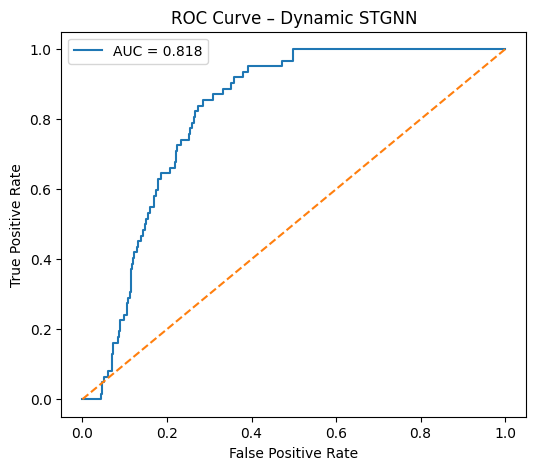

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
y_true_all = []
y_prob_all = []

with torch.no_grad():
    for seq, lbl in test_loader:
        seq = [bt.to(DEVICE) for bt in seq]
        logits = model(seq)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_prob_all.extend(probs)
        y_true_all.extend(lbl.numpy())

fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Dynamic STGNN")
plt.legend()
plt.show()


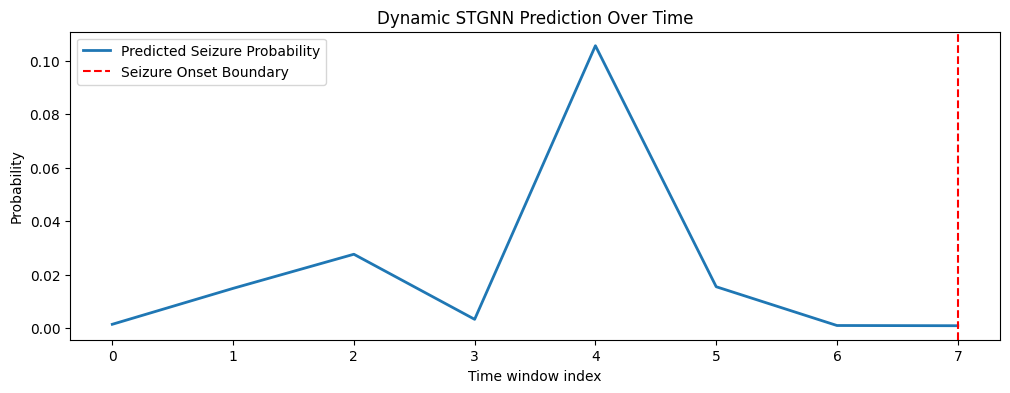

In [ ]:
model.eval()
seq, lbl = next(iter(test_loader))  # 1 batch
seq = [bt.to(DEVICE) for bt in seq]

with torch.no_grad():
    probs = torch.sigmoid(model(seq)).cpu().numpy()

plt.figure(figsize=(12,4))
plt.plot(probs, label="Predicted Seizure Probability", linewidth=2)

plt.axvline(x=len(probs)-1, color='red', linestyle='--', label="Seizure Onset Boundary")
# or use actual start index if you have annotation

plt.xlabel("Time window index")
plt.ylabel("Probability")
plt.title("Dynamic STGNN Prediction Over Time")
plt.legend()
plt.show()


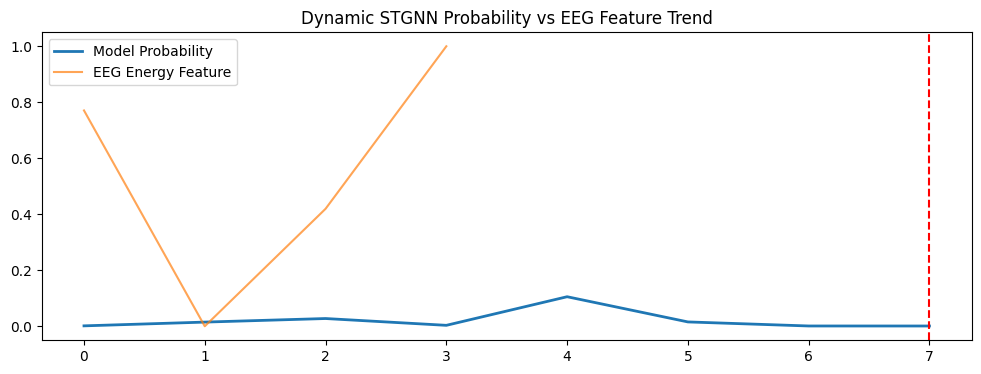

In [ ]:
import numpy as np

# Example summary feature (mean signal energy per window)
summary_feature = []
for bt in seq:  # each timestep batch
    x = bt.x.cpu().numpy()
    summary_feature.append(np.mean(x))

summary_feature = (summary_feature - np.min(summary_feature)) / (np.ptp(summary_feature))

plt.figure(figsize=(12,4))
plt.plot(probs, label="Model Probability", linewidth=2)
plt.plot(summary_feature, label="EEG Energy Feature", alpha=0.7)

plt.axvline(x=len(probs)-1, color='red', linestyle='--')
plt.legend()
plt.title("Dynamic STGNN Probability vs EEG Feature Trend")
plt.show()


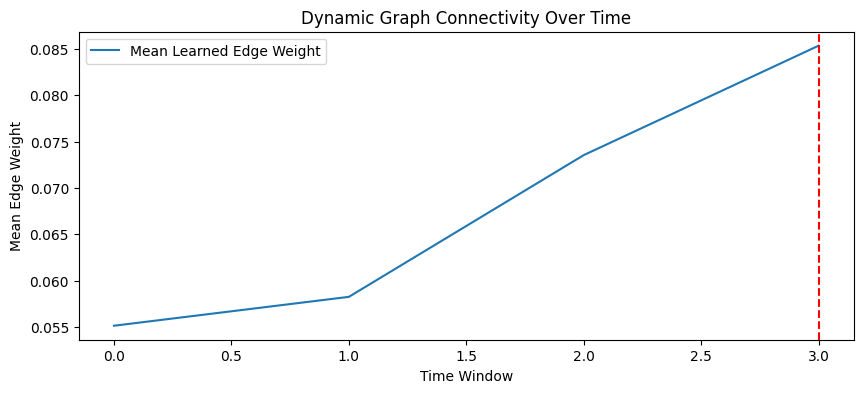

In [ ]:
graph_strength = []

model.eval()
for bt in seq:
    with torch.no_grad():
        bt_gpu = bt.to(DEVICE)
        h = F.relu(model.g1(bt_gpu.x, bt_gpu.edge_index))
        src, dst = bt_gpu.edge_index
        efeat = torch.cat([h[src], h[dst]], dim=1)
        edge_w = model.edge_updater(efeat).squeeze()
        graph_strength.append(edge_w.mean().item())

plt.figure(figsize=(10,4))
plt.plot(graph_strength, label="Mean Learned Edge Weight")
plt.axvline(x=len(graph_strength)-1, color='red', linestyle='--')
plt.title("Dynamic Graph Connectivity Over Time")
plt.xlabel("Time Window")
plt.ylabel("Mean Edge Weight")
plt.legend()
plt.show()


Plotting ROC and PR...


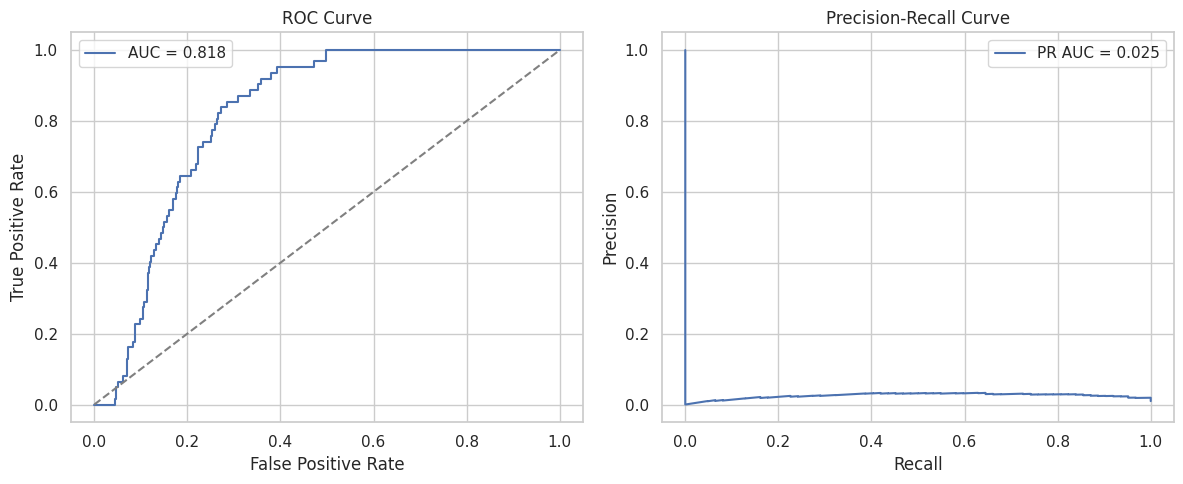


Plotting timeseries for first test batch sample...


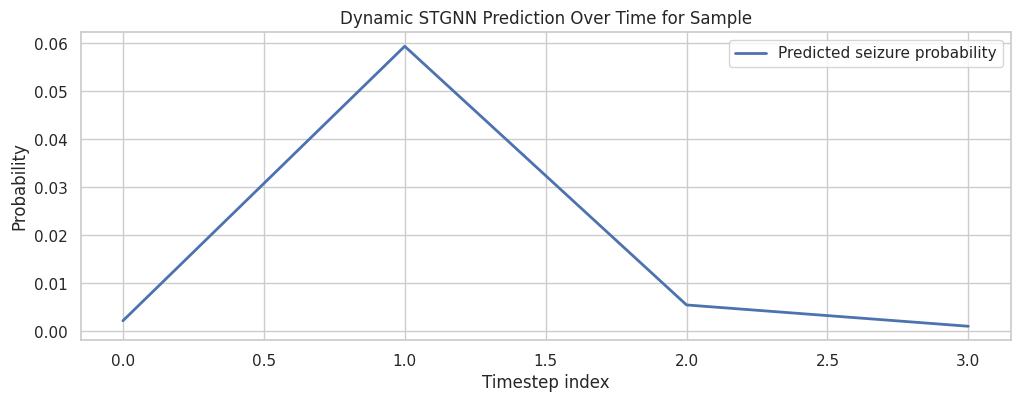


Plotting adjacency heatmaps for first batch, sample 0...


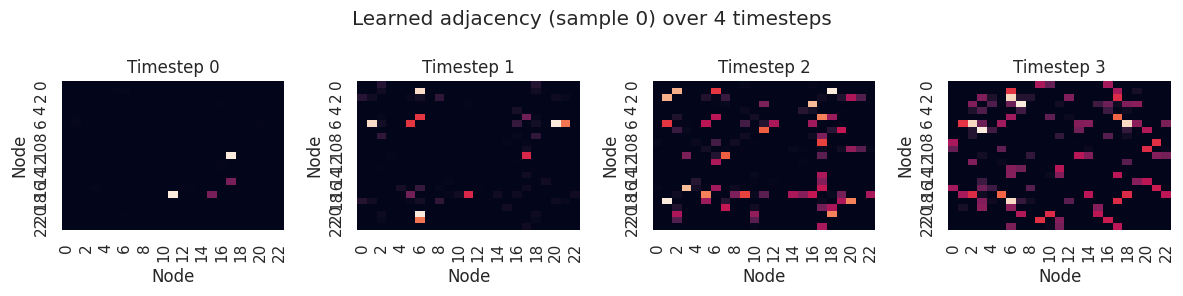


Computing t-SNE of pooled embeddings (first 50 batches)...


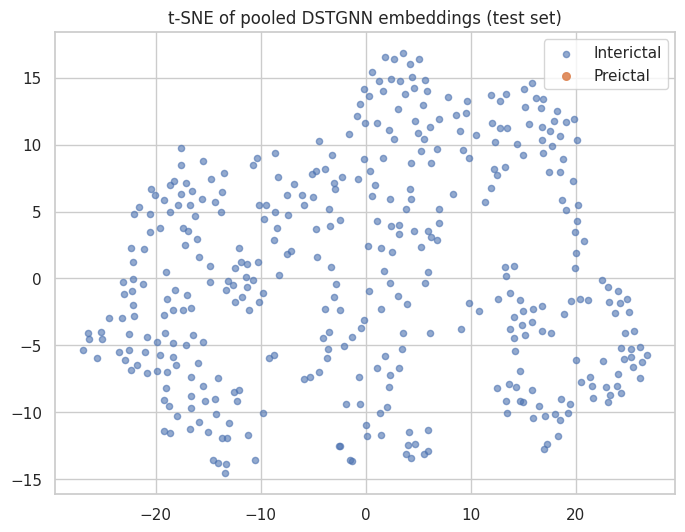


Computing node saliency for first batch/sample/timestep...


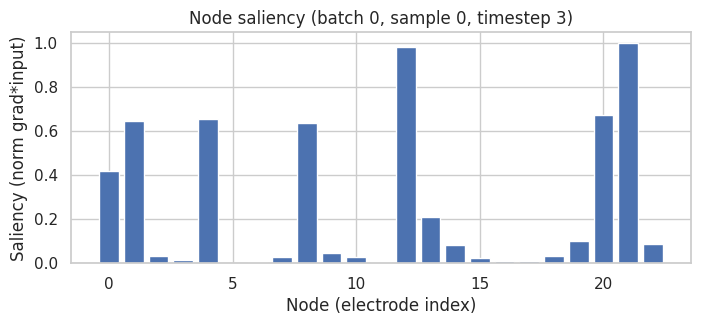

Predicted prob for this sample (fake-seq): 0.0010860793991014361


array([0.4179645 , 0.64574736, 0.03402825, 0.01466165, 0.6550664 ,
       0.        , 0.00449513, 0.03036698, 0.6383843 , 0.04628812,
       0.03025047, 0.00363014, 0.98502874, 0.21083951, 0.08450656,
       0.02492638, 0.00825548, 0.00984394, 0.03463301, 0.10210807,
       0.6734064 , 1.        , 0.08750357], dtype=float32)

In [ ]:
# --- Visualization utilities & plots (paste after your training/eval code) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(style="whitegrid")

# ------- Helper: move list[Batch] -> list[Batch on device] -------
def move_seq_to_device(seq_list, device=DEVICE):
    return [bt.to(device) for bt in seq_list]

# ------- Helper: get single Data objects from a batched Batch -------
def batch_to_data_list(batch):
    # Batch has method to_data_list in recent PyG
    try:
        return batch.to_data_list()
    except:
        # fallback: manual unbatch using batch.num_graphs and mask
        out = []
        n_graphs = int(batch.batch.max().item() + 1)
        for g in range(n_graphs):
            mask = (batch.batch == g)
            x = batch.x[mask]
            # need to remap edge indices: keep edges where both nodes in mask
            edge_index = batch.edge_index.clone()
            edge_attr = batch.edge_attr.clone() if hasattr(batch, "edge_attr") else None
            node_idx = torch.nonzero(mask).squeeze(1)
            # map global indices -> local indices
            map_idx = {int(n.item()): i for i, n in enumerate(node_idx)}
            keep_edges = []
            keep_attrs = []
            for ei in range(edge_index.shape[1]):
                s = int(edge_index[0, ei].item()); d = int(edge_index[1, ei].item())
                if s in map_idx and d in map_idx:
                    keep_edges.append([map_idx[s], map_idx[d]])
                    if edge_attr is not None:
                        keep_attrs.append(edge_attr[ei].cpu().numpy())
            if len(keep_edges) == 0:
                eidx = torch.zeros((2,0), dtype=torch.long)
                eattr = torch.zeros((0,), dtype=torch.float)
            else:
                eidx = torch.tensor(keep_edges, dtype=torch.long).T
                eattr = torch.tensor(keep_attrs, dtype=torch.float) if edge_attr is not None else None
            d = Data(x=x.cpu(), edge_index=eidx, edge_attr=eattr)
            out.append(d)
        return out

# ------- 1) ROC and Precision-Recall (test set) -------
def plot_roc_pr(model, loader):
    model.eval()
    y_true_all = []
    y_prob_all = []
    with torch.no_grad():
        for seq_batch, lbl in loader:
            seq_gpu = [bt.to(DEVICE) for bt in seq_batch]
            logits = model(seq_gpu)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            y_prob_all.extend(probs.tolist())
            y_true_all.extend(lbl.numpy().tolist())

    y_true_all = np.array(y_true_all)
    y_prob_all = np.array(y_prob_all)

    if len(np.unique(y_true_all)) < 2:
        print("ROC/PR: only one class present in test set -> can't compute ROC/PR.")
        return

    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    roc_auc = auc(fpr, tpr)

    prec, rec, _ = precision_recall_curve(y_true_all, y_prob_all)
    pr_auc = auc(rec, prec)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------- 2) Time-series: model probs vs EEG summary feature (first batch) -------
def plot_timeseries_sample(model, loader, sample_idx=0):
    model.eval()
    batch, labels = next(iter(loader))

    # --- pick one sample ---
    seq = [bt[sample_idx].to(DEVICE) for bt in batch]   # list of Data objects
    true_label = labels[sample_idx].item()

    per_timestep_probs = []

    with torch.no_grad():
        # iterate through seq, but give model the *same* seq for GRU each time
        for t in range(len(seq)):
            # drift a single timestamp; replicate it into fake sequence
            single_batch = seq[t]
            fake_seq = [single_batch for _ in range(len(seq))]

            logits_fake = model(fake_seq)

            # FIX: detach before numpy()
            prob = torch.sigmoid(logits_fake).detach().cpu().numpy()[0]

            per_timestep_probs.append(float(prob))

    per_timestep_probs = np.array(per_timestep_probs)

    # --- plot ---
    plt.figure(figsize=(12,4))
    plt.plot(per_timestep_probs, label="Predicted seizure probability", linewidth=2)

    # highlight true seizure onset if exists
    if true_label == 1:
        plt.axvline(x=len(seq)-1, color="red", linestyle="--", label="True seizure label")

    plt.title("Dynamic STGNN Prediction Over Time for Sample")
    plt.xlabel("Timestep index")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.show()


# ------- 3) Dynamic adjacency heatmaps for first sample in a batch -------
def adjacency_heatmaps_over_time(model, loader, batch_choice=0, sample_choice=0, use_weighted=True):
    model.eval()
    seq_batch, lbl = list(loader)[batch_choice]  # pick the chosen batch (careful with large test sets)
    # seq_batch: list[Batch]
    heatmaps = []
    node_counts = []
    for bt in seq_batch:
        # get list of Data from batched Batch
        dlist = batch_to_data_list(bt)
        if sample_choice >= len(dlist):
            # pad
            heatmaps.append(None); node_counts.append(0); continue
        d = dlist[sample_choice]
        # compute learned edge weights using model.g1 and model.edge_updater
        d_gpu = Data(x=d.x.to(DEVICE), edge_index=d.edge_index.to(DEVICE))
        ea = d.edge_attr.to(DEVICE) if hasattr(d, "edge_attr") and d.edge_attr is not None else None
        with torch.no_grad():
            h = F.relu(model.g1(d_gpu.x, d_gpu.edge_index, edge_weight=ea) if ea is not None else model.g1(d_gpu.x, d_gpu.edge_index))
            # compute edge updater values
            src, dst = d_gpu.edge_index
            efeat = torch.cat([h[src], h[dst]], dim=1)
            edge_w = model.edge_updater(efeat).squeeze()  # (num_edges,)
            # combine with initial edge_attr (correlation) optionally
            if use_weighted and ea is not None:
                final_w = (edge_w * ea.to(DEVICE)).cpu().numpy()
            else:
                final_w = edge_w.cpu().numpy()
        # construct adjacency matrix
        n = d.x.shape[0]
        A = np.zeros((n, n), dtype=float)
        edges = d.edge_index.cpu().numpy().T
        for idx_e, (s, t) in enumerate(edges):
            A[s, t] = final_w[idx_e]
        # optional symmetricize by average
        A = (A + A.T) / 2.0
        heatmaps.append(A)
        node_counts.append(n)

    # Plot heatmaps in a row
    n_plots = len([h for h in heatmaps if h is not None])
    fig, axes = plt.subplots(1, n_plots, figsize=(3*n_plots, 3))
    if n_plots == 1:
        axes = [axes]
    pi = 0
    for i, H in enumerate(heatmaps):
        if H is None: continue
        sns.heatmap(H, ax=axes[pi], cbar=False)
        axes[pi].set_title(f"Timestep {i}")
        axes[pi].set_xlabel("Node"); axes[pi].set_ylabel("Node")
        pi += 1
    plt.suptitle(f"Learned adjacency (sample {sample_choice}) over {len(heatmaps)} timesteps")
    plt.tight_layout()
    plt.show()

# ------- 4) Latent space t-SNE of pooled embeddings across test set -------
def compute_pooled_embeddings_for_loader(model, loader, max_batches=None):
    model.eval()
    emb_list = []
    lbl_list = []
    with torch.no_grad():
        for bidx, (seq_batch, lbl) in enumerate(loader):
            # seq_batch list[Batch]
            # for each batch, compute pooled graph-level embedding exactly as model does per timestep, then feed through GRU to get final hidden state
            # We'll reuse model internals: compute per-timestep pooled embeddings, then run GRU
            seq_gpu = [bt.to(DEVICE) for bt in seq_batch]
            embeds = []
            for bt in seq_gpu:
                x, ei = bt.x, bt.edge_index
                ea = bt.edge_attr if hasattr(bt, "edge_attr") else None
                h = F.relu(model.g1(x, ei, edge_weight=ea) if ea is not None else model.g1(x, ei))
                src, dst = ei
                efeat = torch.cat([h[src], h[dst]], dim=1)
                edge_w = model.edge_updater(efeat).squeeze()
                h2 = F.relu(model.g2(h, ei, edge_weight=edge_w))
                g_emb = global_mean_pool(h2, bt.batch)  # (B, hidden)
                embeds.append(g_emb.unsqueeze(1))
            seq_tensor = torch.cat(embeds, dim=1)  # (B, SEQ_LEN, hidden)
            # pass through GRU and take last hidden
            out, _ = model.gru(seq_tensor.to(DEVICE))
            final = out[:, -1, :].cpu().numpy()  # (B, hidden)
            emb_list.append(final)
            lbl_list.append(lbl.numpy())
            if max_batches is not None and bidx+1 >= max_batches:
                break
    if len(emb_list) == 0:
        return None, None
    X = np.vstack(emb_list)
    y = np.concatenate(lbl_list)
    return X, y

def plot_tsne_embeddings(model, loader, n_batches=None):
    X, y = compute_pooled_embeddings_for_loader(model, loader, max_batches=n_batches)
    if X is None:
        print("No embeddings computed.")
        return
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    Z = tsne.fit_transform(X)
    plt.figure(figsize=(8,6))
    plt.scatter(Z[y==0,0], Z[y==0,1], label='Interictal', alpha=0.6, s=20)
    plt.scatter(Z[y==1,0], Z[y==1,1], label='Preictal', alpha=0.9, s=30)
    plt.legend(); plt.title("t-SNE of pooled DSTGNN embeddings (test set)")
    plt.show()

# ------- 5) Node saliency via gradient * input for a chosen sample/timestep -------
def node_saliency_for_sample(model, loader, batch_choice=0, sample_choice=0, timestep_choice=0):
    model.eval()
    seq_batch, lbl = list(loader)[batch_choice]
    # get Data for chosen timestep and chosen sample
    bt = seq_batch[timestep_choice]
    dlist = batch_to_data_list(bt)
    if sample_choice >= len(dlist):
        print("sample_choice out of range")
        return
    d = dlist[sample_choice]
    # prepare single graph and ensure requires_grad on x
    x = d.x.clone().detach().requires_grad_(True).to(DEVICE)
    edge_index = d.edge_index.to(DEVICE)
    ea = d.edge_attr.to(DEVICE) if hasattr(d, "edge_attr") and d.edge_attr is not None else None

    # Forward pass to get model logit for this sample: build fake sequence by repeating this graph SEQ_LEN times
    fake_batch = Batch.from_data_list([Data(x=x, edge_index=edge_index, edge_attr=ea)])
    fake_seq = [fake_batch.to(DEVICE) for _ in range(SEQ_LEN)]
    logits = model(fake_seq)  # shape (1,)
    prob = torch.sigmoid(logits)[0]
    # backward w.r.t x
    model.zero_grad()
    prob.backward(retain_graph=True)
    # grads wrt x are in x.grad
    grads = x.grad.detach().cpu().numpy()  # (N_nodes, feat_dim)
    # saliency score per node: L2 norm of grad * input (gradient*input)
    scores = np.linalg.norm(grads * d.x.cpu().numpy(), axis=1)
    # normalize
    if np.ptp(scores) > 0:
        scores = (scores - scores.min()) / (np.ptp(scores))
    # plot bar
    plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(scores)), scores)
    plt.xlabel("Node (electrode index)"); plt.ylabel("Saliency (norm grad*input)")
    plt.title(f"Node saliency (batch {batch_choice}, sample {sample_choice}, timestep {timestep_choice})")
    plt.show()

    print("Predicted prob for this sample (fake-seq):", float(prob.cpu().item()))
    return scores

# -------------------- Run visuals --------------------
print("Plotting ROC and PR...")
plot_roc_pr(model, test_loader)

print("\nPlotting timeseries for first test batch sample...")
plot_timeseries_sample(model, test_loader, sample_idx=0)

print("\nPlotting adjacency heatmaps for first batch, sample 0...")
adjacency_heatmaps_over_time(model, test_loader, batch_choice=0, sample_choice=0, use_weighted=True)

print("\nComputing t-SNE of pooled embeddings (first 50 batches)...")
plot_tsne_embeddings(model, test_loader, n_batches=50)

print("\nComputing node saliency for first batch/sample/timestep...")
node_saliency_for_sample(model, test_loader, batch_choice=0, sample_choice=0, timestep_choice=SEQ_LEN-1)
